In [23]:
import numpy as np
from astropy.cosmology import z_at_value, FlatLambdaCDM
import astropy.units as u

In [24]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

In [25]:
fermi_grbs = [
    {'grb': '170214A', 'e_peak': 408.5,'fluence': 1.8e-4, 'z': 2.53 },
    {'grb': '160625B', 'e_peak': 68., 'fluence': 1.7e-6, 'z': 1.41 },
    {'grb': '160623A', 'e_peak': 562., 'fluence': 6.6e-4, 'z': 0.37},
    {'grb': '160509A', 'e_peak': 370., 'fluence': 1.5e-4, 'z': 1.17},
    {'grb': '150514A', 'e_peak': 73.,  'fluence': 4.9e-6, 'z': 0.81},
#    {'grb': '131011A', 'e_peak': 220., 'fluence': 6.6e-5, 'z': 1.87}
]

In [26]:
def amati_Ep2Eiso_log(Ep, A = 2.07, B = 0.49):
    """log(Epeak [keV]) = 2.07+0.49*log(Eiso/1e52) from arXiv:1612.00618v3 Dainotti et al.
       returns E_iso x 10^52 erg"""
    logEp = np.log10(Ep)
    logEiso = (logEp - A)/B
    return 10**(logEiso+52.)

In [27]:
def amatiE_peak2E_iso(E_peak,m=0.49,K=90., e0=1e52):
    """Calculates E_peak from 'famous' Amati relation
    E_p [keV] = K * (E_iso[1e52 erg])**m
    """
    return e0*(E_peak/K)**(1./m)

In [28]:
def solve_iter(dl, dTarget):
    """Iterator that calculates the range of redshifts and compares the function with the target value
    """

    tolerance = 0.001

    zMin = 0.0
    zMax = 10.0

    diff = dl(zMax) - dTarget
    while diff < 0:
        zMax = zMax + 5.0
        diff = dl(zMax) - dTarget

    zTrial = zMin + (zMax - zMin) / 2.0

    dTrial = dl(zTrial)
    diff = dTrial - dTarget
    while abs(diff)/dTarget > tolerance:

        if diff > 0:
            zMax = zMax - (zMax - zMin) / 2.0
        else:
            zMin = zMin + (zMax - zMin) / 2.0

        zTrial = zMin + (zMax - zMin) / 2.0
        dTrial = dl(zTrial)
        diff = dTrial - dTarget

    return zTrial

In [29]:
def calc_redshift(e_peak, fluence):
    e_iso = amati_Ep2Eiso_log(e_peak) # log version of Amati, Dainotti
    #e_iso = amatiE_peak2E_iso(e_peak) # Amati in Amati
    #e_iso = amatiE_peak2E_iso(e_peak, m=0.5, K=400., e0=1e53) # Amati used by Andrew
    dlz2_target = e_iso/(4.*np.pi*fluence)
    dlz_target = np.sqrt(dlz2_target)
    #z_amati_dc = solve_iter(cosmo.comoving_distance,dlz_target*u.cm) # switch between two solvers of z from dc(z)
    z_amati_dc = z_at_value(cosmo.comoving_distance, dlz_target*u.cm)
    return e_iso, dlz_target*u.cm, z_amati_dc

In [30]:
z_measured = []
z_amati = []
for grb in fermi_grbs:
    z_measured.append(grb['z'])
    e_iso, dc, z = calc_redshift(grb['e_peak'], grb['fluence'])
    print "grb", grb['grb'], grb['fluence'], grb['e_peak'], grb['z'], z
    z_amati.append(z)

grb 170214A 0.00018 408.5 2.53 0.674262943102
grb 160625B 1.7e-06 68.0 1.41 1.31911871748
grb 160623A 0.00066 562.0 0.37 0.460404998936
grb 160509A 0.00015 370.0 1.17 0.666207463195
grb 150514A 4.9e-06 73.0 0.81 0.712348001523


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

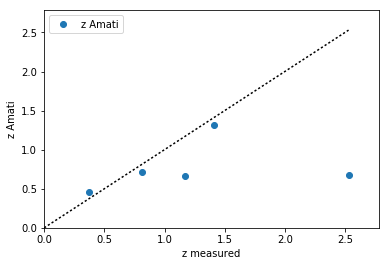

In [32]:
plt.plot(z_measured, z_amati, "o", label="z Amati")
z_max = max(max(z_amati),max(z_measured))
plt.plot([0,z_max],[0,z_max],linestyle=":", color="black")
plt.xlim([0,1.1*z_max])
plt.ylim([0,1.1*z_max])
plt.xlabel('z measured')
plt.ylabel('z Amati')
plt.legend()